In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv('CLTV.csv')

In [3]:
df.info()
#No null values noticed, 16 categorical variables, 8 numeric variables(including the dependent variable)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [4]:
(df.isna().sum()/7043)*100
#Clean dataset: No nulls

Customer                         0.0
State                            0.0
Customer Lifetime Value          0.0
Response                         0.0
Coverage                         0.0
Education                        0.0
Effective To Date                0.0
EmploymentStatus                 0.0
Gender                           0.0
Income                           0.0
Location Code                    0.0
Marital Status                   0.0
Monthly Premium Auto             0.0
Months Since Last Claim          0.0
Months Since Policy Inception    0.0
Number of Open Complaints        0.0
Number of Policies               0.0
Policy Type                      0.0
Policy                           0.0
Renew Offer Type                 0.0
Sales Channel                    0.0
Total Claim Amount               0.0
Vehicle Class                    0.0
Vehicle Size                     0.0
dtype: float64

In [5]:
df.describe(include = np.object).T

,count,unique,top,freq
Customer,9134,9134,KY38074,1
State,9134,5,California,3150
Response,9134,2,No,7826
Coverage,9134,3,Basic,5568
Education,9134,5,Bachelor,2748
Effective To Date,9134,59,1/10/11,195
EmploymentStatus,9134,5,Employed,5698
Gender,9134,2,F,4658
Location Code,9134,3,Suburban,5779
Marital Status,9134,3,Married,5298


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer Lifetime Value,9134.0,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.381190
Income,9134.0,37657.380009,30379.904734,0.000000,0.000000,33889.500000,62320.000000,99981.000000
Monthly Premium Auto,9134.0,93.219291,34.407967,61.000000,68.000000,83.000000,109.000000,298.000000
Months Since Last Claim,9134.0,15.097000,10.073257,0.000000,6.000000,14.000000,23.000000,35.000000
Months Since Policy Inception,9134.0,48.064594,27.905991,0.000000,24.000000,48.000000,71.000000,99.000000
Number of Open Complaints,9134.0,0.384388,0.910384,0.000000,0.000000,0.000000,0.000000,5.000000
Number of Policies,9134.0,2.966170,2.390182,1.000000,1.000000,2.000000,4.000000,9.000000
Total Claim Amount,9134.0,434.088794,290.500092,0.099007,272.258244,383.945434,547.514839,2893.239678


It seems unusual that 'Number of policies' has entries with value >1, given that each record denotes details per person, per vehicle, auto insurance only.

We shall scrutinize this below, utilizing some domain knowledge.

In [7]:
df[['Effective To Date', 'Number of Policies', 'Months Since Policy Inception']]

,Effective To Date,Number of Policies,Months Since Policy Inception
0,2/24/11,1,5
1,1/31/11,8,42
2,2/19/11,2,38
3,1/20/11,7,65
4,2/3/11,1,44
...,...,...,...
9129,2/10/11,2,89
9130,2/12/11,1,28
9131,2/6/11,2,37
9132,2/3/11,3,3


The dataset does not mention whether a customer owns just 1 or >1 vehicles. It is not possible to have multiple policies against the same vehicle by the same insurer. The cases where the Number of poilicies are >1, hence implies that the customer owns >1 vehicle (no data to show this) or, they may have re-purchased a policy multiple times in the same year, for some reason.

For eg. if a person who has a 6-month long policy repurchases it once it's over, it will show up as him having 2 policies for the same vehicle in that year. The same can happen if a person buys a new policy after the old one relapses/gets cancelled due to non-payment. Auto-insurance policies are ususally for either 6 months or 1 year. Occasionally it could be month-to-month.

In light of the above, the following information is needed, but missing: 
- Has the current policy been continuos since inception? 
- Does the customer use 6-month or 1-year policy?
- Were there payment gaps or periods of policy relapse since the inception (i.e. do the 'Months Since Policy inception' also include months where the customer was not actively submitted into a policy)?
- Does the customer have >1 vehicles insured with us?

Let us scrutinize the above 3 columns more to see if extra information can be extracted that can make our modeling more meaningful.

In [8]:
print("Unique months: ", pd.to_datetime(df['Effective To Date']).dt.month.unique())
print("Unique Years: ", pd.to_datetime(df['Effective To Date']).dt.year.unique())
print("Unique no. of days: ", pd.to_datetime(df['Effective To Date']).dt.day.nunique())

#for the given dataset, policies run only into January or February 2011.

Unique months:  [2 1]
Unique Years:  [2011]
Unique no. of days:  31


In [9]:
df[df['Number of Policies']==1][['Months Since Policy Inception', 'Number of Policies']]

,Months Since Policy Inception,Number of Policies
0,5,1
4,44,1
16,7,1
17,59,1
20,21,1
...,...,...
9120,69,1
9121,35,1
9128,58,1
9130,28,1


It is unusual to note that there are durations over 2 or 3 years even when the number of policies is just 1. 
I would have expected the months of inception to be <=12 months if number of policies=1

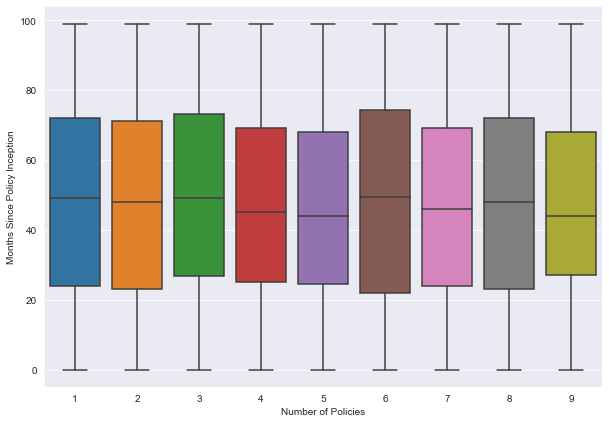

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,7))   
sns.boxplot('Number of Policies', 'Months Since Policy Inception', data=df)

No trend to be observed between Number of policies and Months Since policy inception. This definitely indicates missing variables or information. We shall finalize on how to handle this scenario during modeling, after EDA

# Exploratory Data Analysis 

## Univariate analysis:

In [11]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

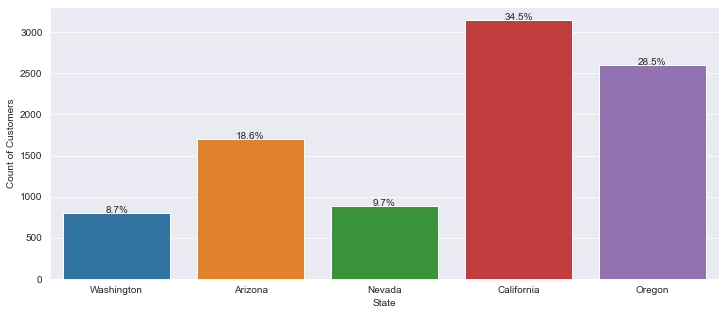

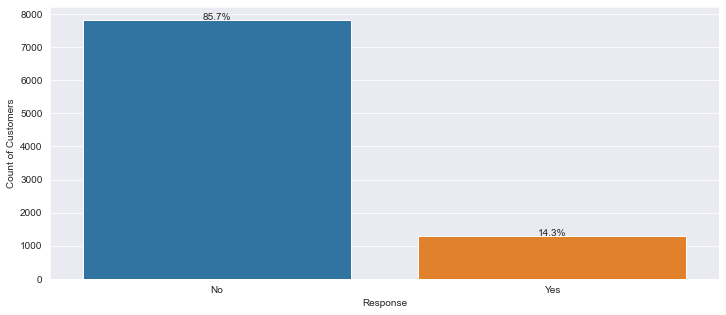

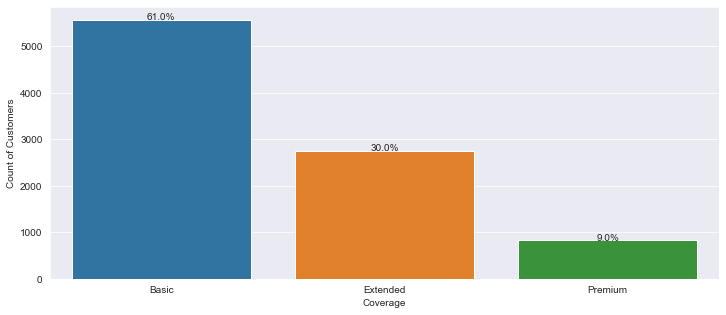

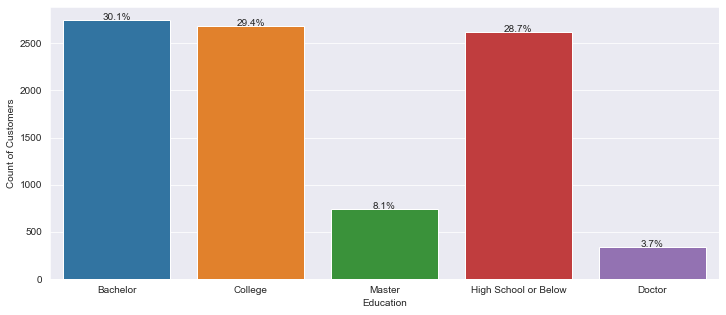

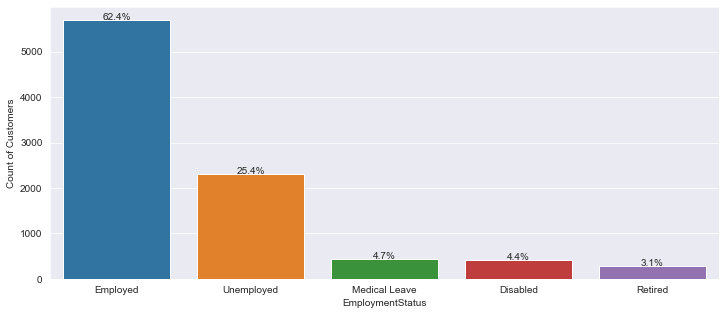

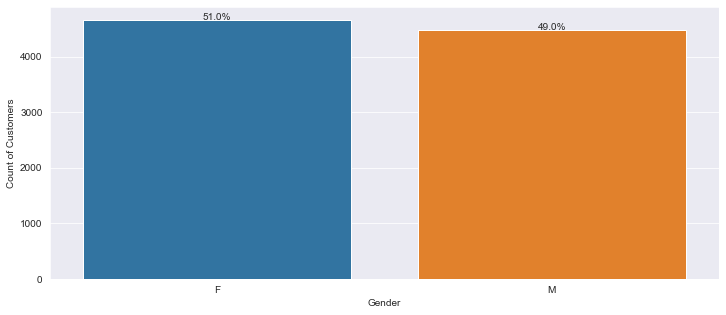

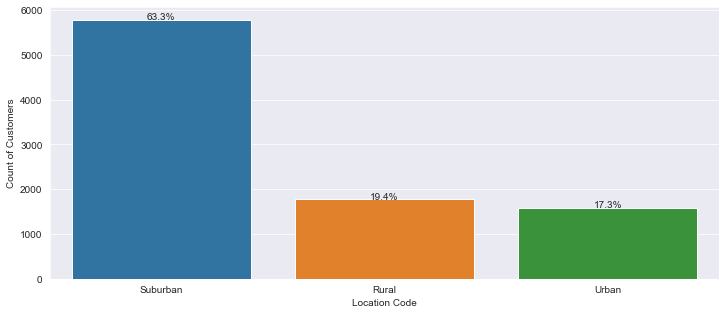

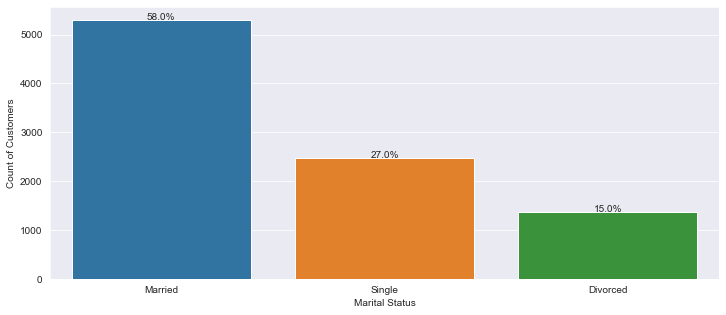

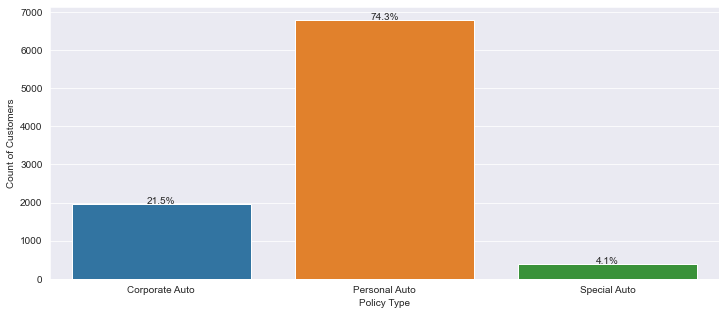

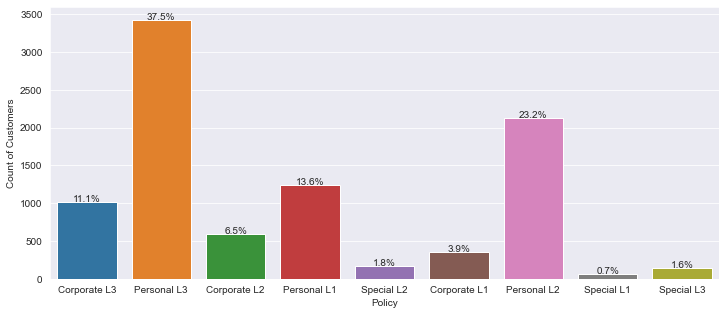

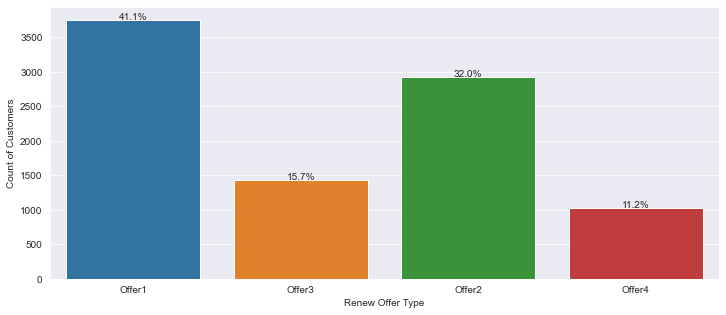

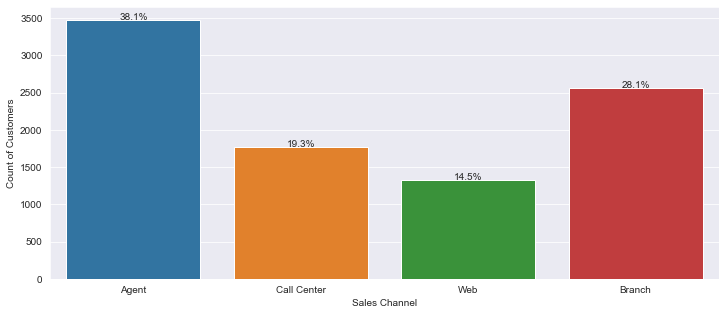

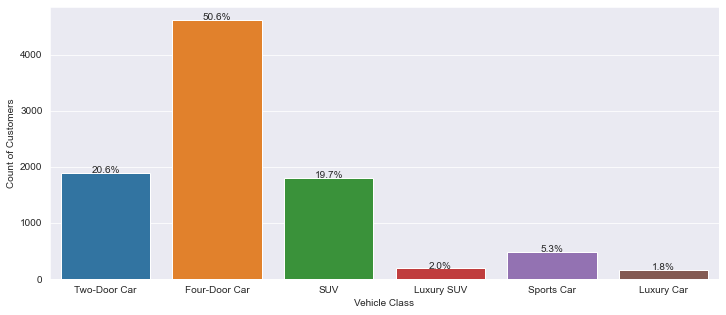

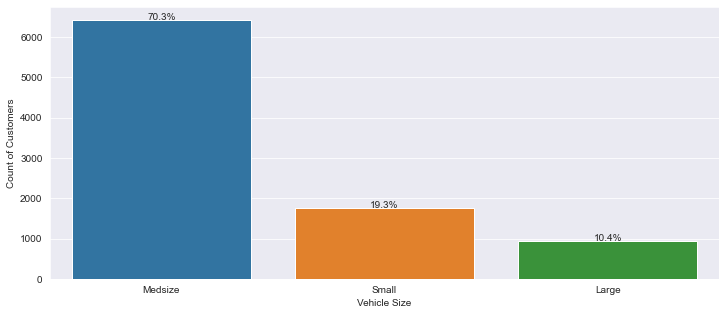

In [12]:
sns.set_style('darkgrid')
def annot(ax, total=len(df)):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.1f}%'.format(height*100/total), ha="center")
for i in df.describe(include = np.object).columns.drop(['Customer', 'Effective To Date']):
    plt.figure(figsize=(12,5))
    ax=sns.countplot(x=i, data=df)
    ax.set(ylabel="Count of Customers")
    annot(ax)
plt.show()

Key Observations:

1. The dataset has customers from 5 states- majority are from California, followed by Oregon
2. 85.7% have given 'No' response to marketing communications/new Offers.
3. More than half the customers have opted for the Basic auto-insurance.
4. Those with High School & Below, Bachelor's or College education, constitute majority of the insurance takers. The numbers drop drastically as they enter Master's or Doctorate. This is a bit unexpected. It is possible that the given insurance brand may not be having attractive offers for higher education students, and hence fails to attracts those segments. 
5. As expected, majority of the insurance-takers are 'Employed'. 
6. Most customers are from the Suburban region. Personal auto-insurance is the most purchased (Personal L3)
7. Majority customers are obtained by agents and possess 4-ddor, medium size vehicles.

We will rebucket the 'Education' and 'EmploymentStatus' variable & perform bivariate analysis on select variables against Customer lifetime values, Income, Monthly premium auto, and Total Claim amount, as appropriate.

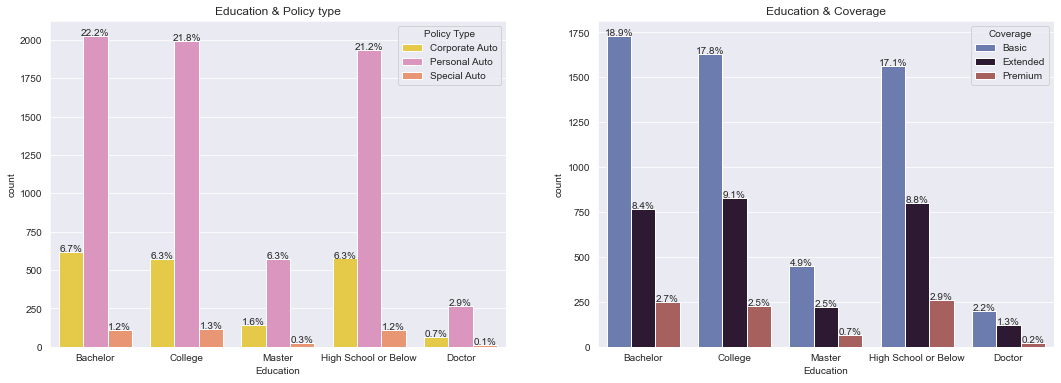

In [13]:
# sns.countplot(x='Education', hue='Coverage', data=df)
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
ax=sns.countplot(x='Education', hue='Policy Type', data=df, palette='Set2_r')
ax.set(title='Education & Policy type')
annot(ax)
plt.subplot(1,2,2)
ax=sns.countplot(x='Education', hue='Coverage', data=df, palette='twilight')
ax.set(title='Education & Coverage')
annot(ax)

#No unusual trends observed. The dominance of 'Personal auto' as the most purchased insurance
# and 'Basic' as the most preferred Coverage type, can be seen across the education categories.

In [3]:
#Re-bucketing Education
def change(x):
    if x in ['Bachelor', 'College', 'High School or Below']:
        return 'Bachelor or Below'
    else:
        return x
df['Education']=df['Education'].apply(change)

In [4]:
#Re-bucketing Employment Status
def func(y):
    if y in ['Medical Leave', 'Disabled', 'Retired']:
        return 'Retired_Others'
    else:
        return y
df['EmploymentStatus']=df['EmploymentStatus'].apply(func)

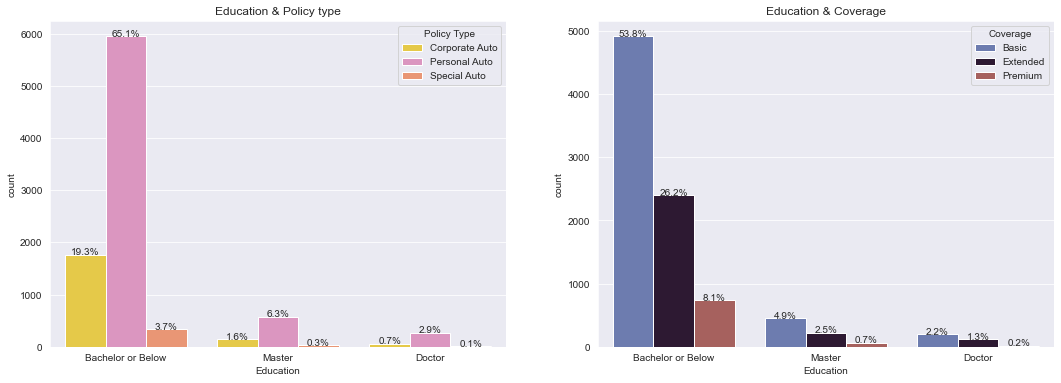

In [16]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
ax=sns.countplot(x='Education', hue='Policy Type', data=df, palette='Set2_r')
ax.set(title='Education & Policy type')
annot(ax)
plt.subplot(1,2,2)
ax=sns.countplot(x='Education', hue='Coverage', data=df, palette='twilight')
ax.set(title='Education & Coverage')
annot(ax)

#The trends stay the same, but the re-bucketing has made the classes in 'Education' more distinct

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B5B3288E48>,
      dtype=object)

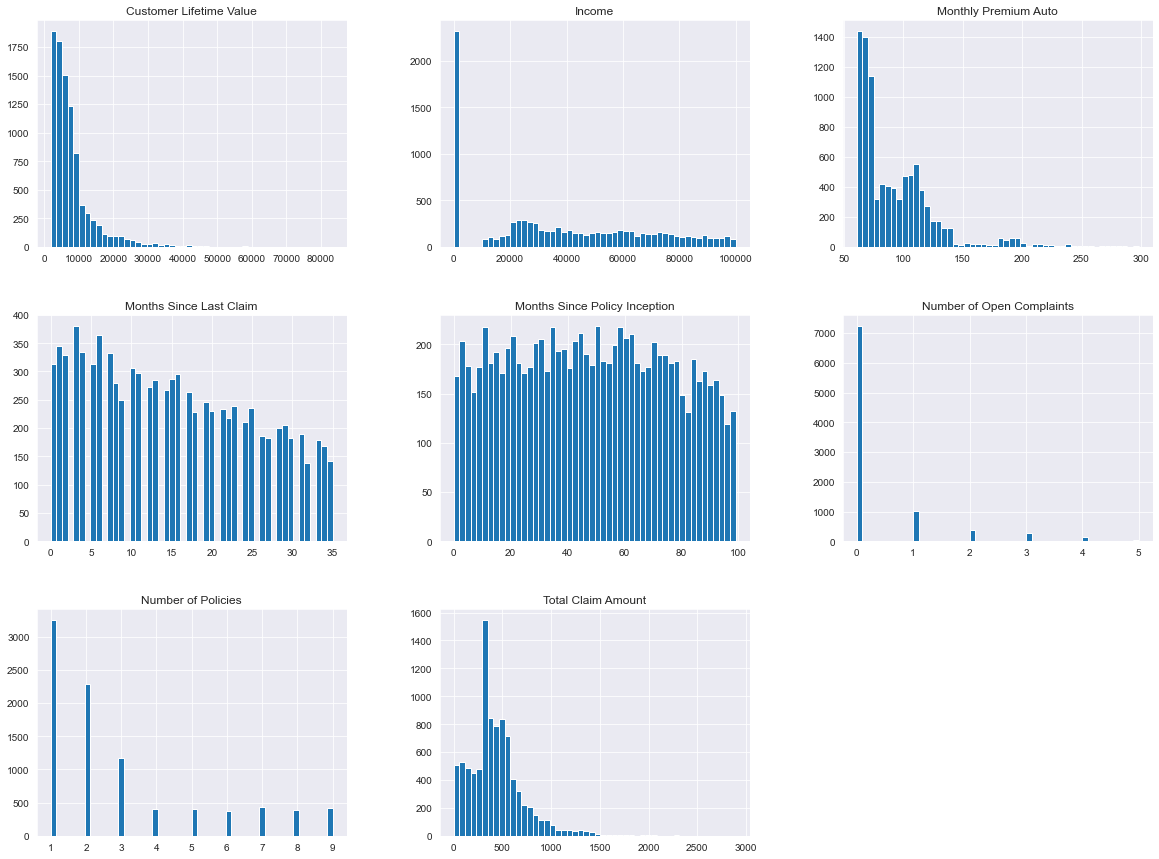

In [17]:
df.hist(bins=50, figsize=(20,15))
#Customer Lifetime Value is right skewed. So is Monthly premium auto

## Bivariate Analysis

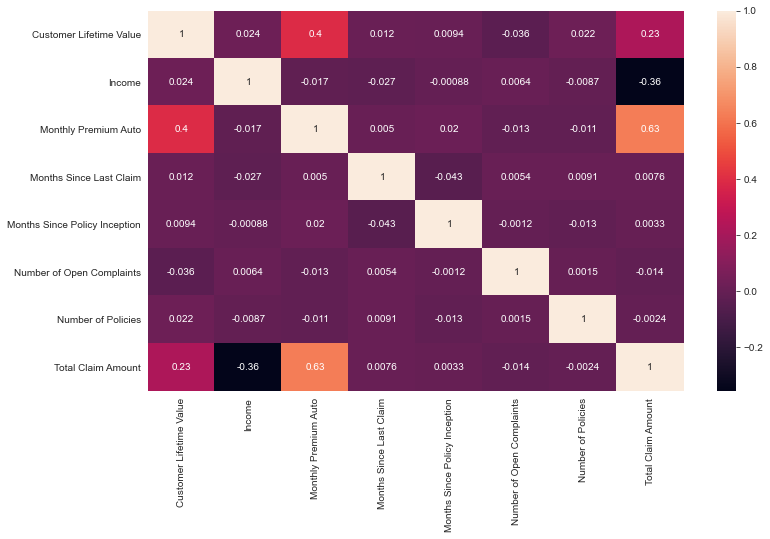

In [49]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), cbar=True, annot=True)

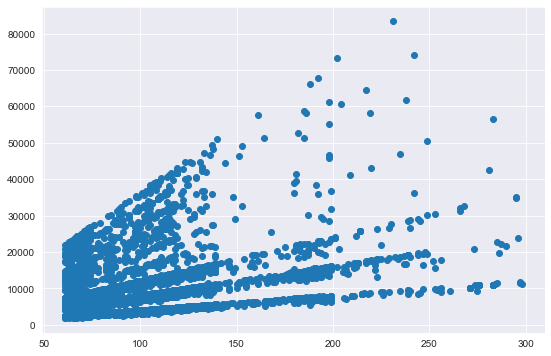

In [18]:
#Monthly premium auto Vs Customer Lifetime Value
plt.figure(figsize=(9,6))
plt.scatter(df['Monthly Premium Auto'], df['Customer Lifetime Value'])

Customer Lifetime is definitely increasing as a person pays more monthly premium auto. This probably indicates brand loyalty, customer satisfaction etc. 

There appears to exist underlying classes in the above plot. We shall examine the same below:

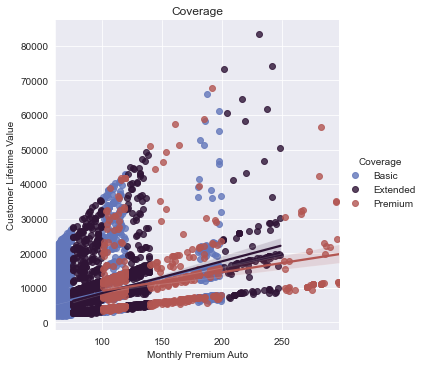

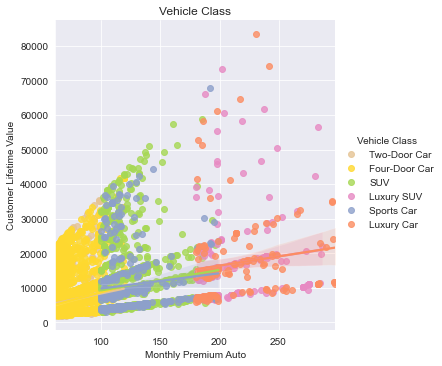

In [19]:
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
plt.close()
ax=sns.lmplot('Monthly Premium Auto', 'Customer Lifetime Value', hue='Coverage', palette='twilight',data=df)
ax.set(title="Coverage")
plt.show()
plt.subplot(1,2,2)
plt.close()
ax=sns.lmplot('Monthly Premium Auto', 'Customer Lifetime Value', hue='Vehicle Class', palette='Set2_r',data=df)
ax.set(title="Vehicle Class")
plt.show()

A certain trend in Customer Lifetime value is observed when Coverage is considered. 'Basic' is opted more by those that pay monthly auto premium in the smaller brackets, and gets more dispersed as we move ahead in the monthly auto premium. A certain hierarchy seems to be loosely followed by the 3 coverage categories.

The divide is more obvious when Vehicle Class is considered. The number of Sports car or luxury car owners in the lower monthly-auto-premium range (<$100) is almost none. Luxury car owners almost always opt for more monthly premium than sports car owners and have more Customer Lifetime values.

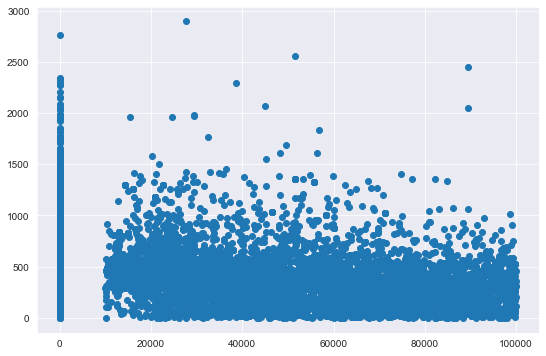

In [20]:
#Income Vs Total Claim Amount
plt.figure(figsize=(9,6))
plt.scatter(df['Income'], df['Total Claim Amount'])
#No noticeable trend

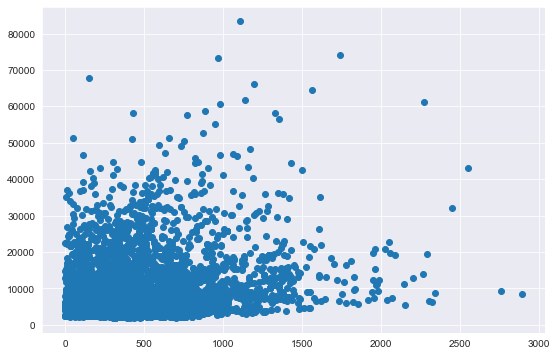

In [112]:
#Total Claim Amount vs Customer Lifetime Value
plt.figure(figsize=(9,6))
plt.scatter(df['Total Claim Amount'], df['Customer Lifetime Value'])
#An overall or rough positive relationship oobserved.

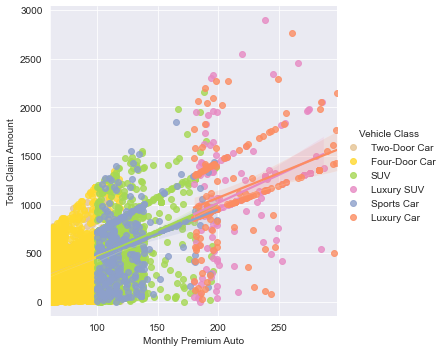

In [21]:
#Monthly premium auto vs Total claim amount
sns.lmplot('Monthly Premium Auto', 'Total Claim Amount', hue='Vehicle Class', palette='Set2_r',data=df)
#Fairly strong positive relationship observed. Divide between different vehicle sizes evident.

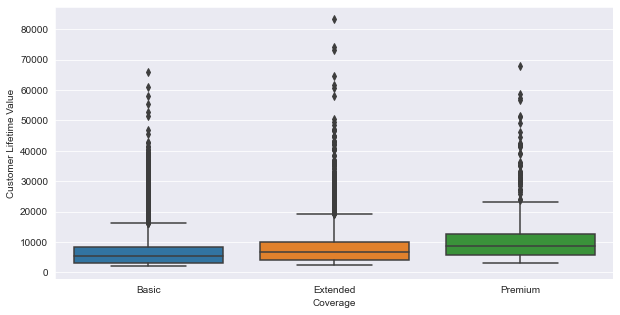

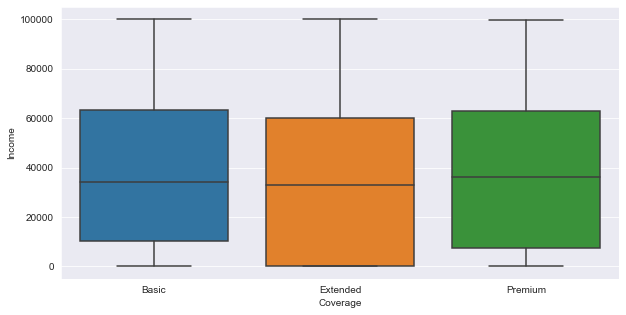

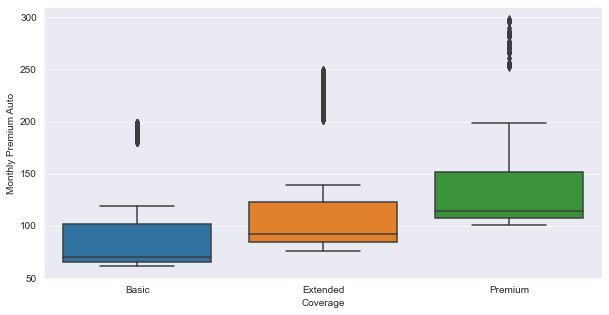

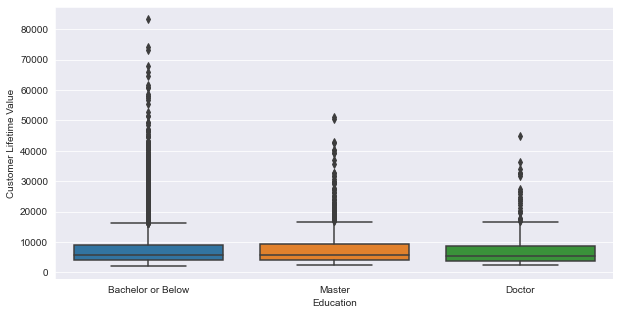

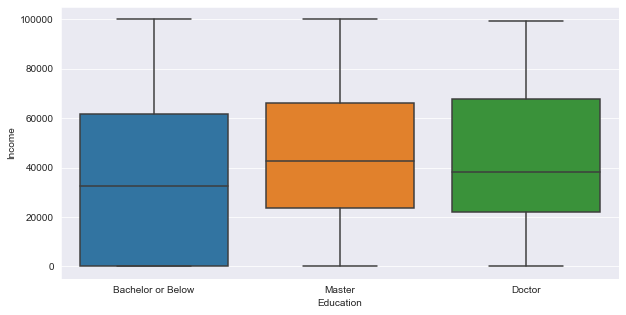

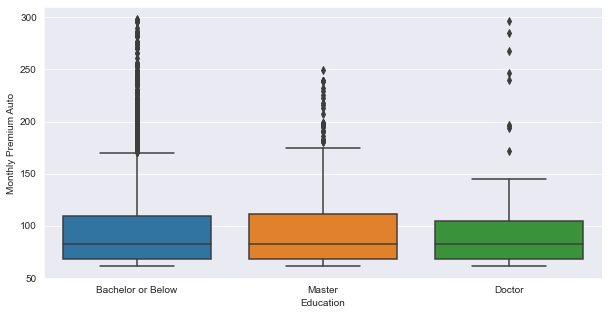

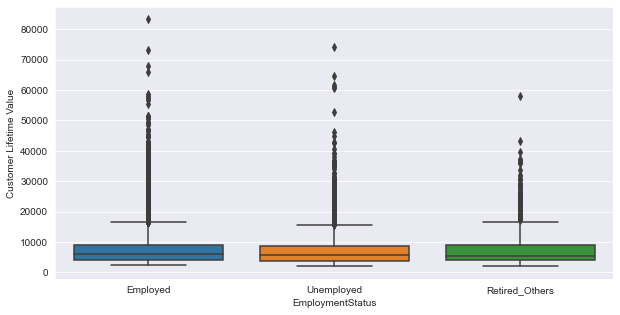

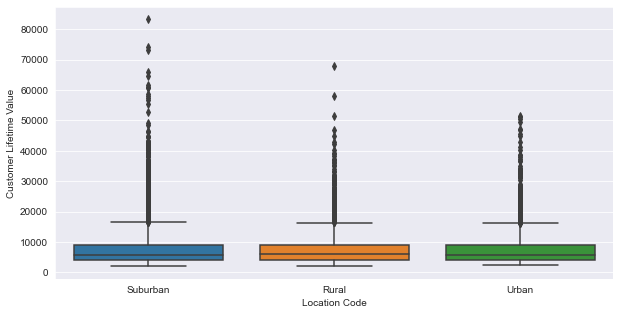

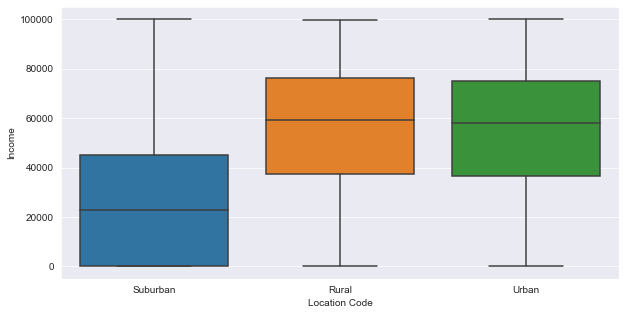

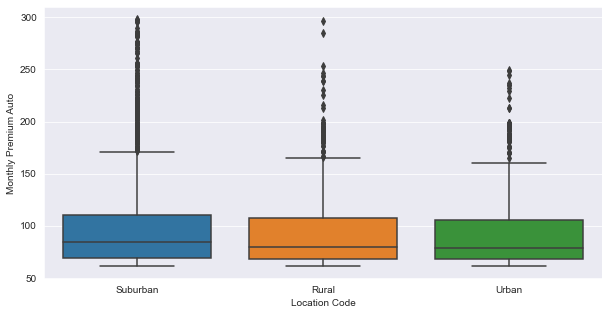

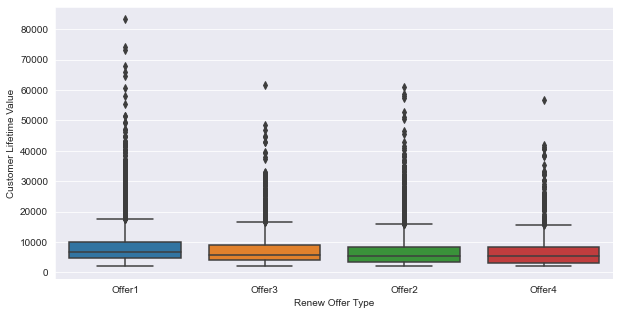

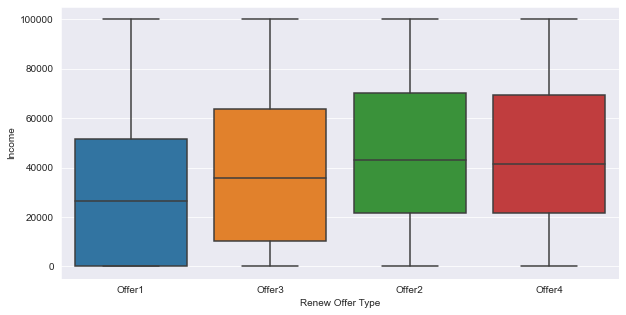

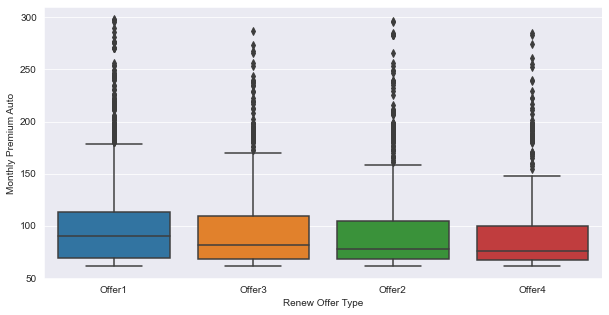

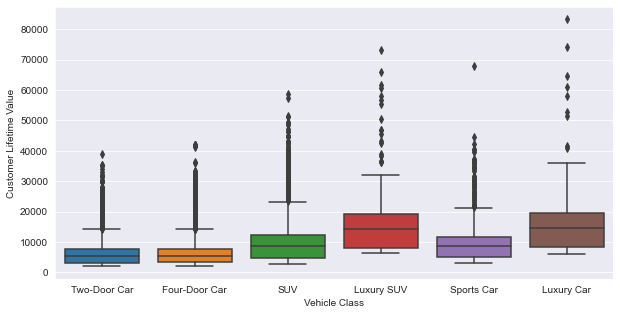

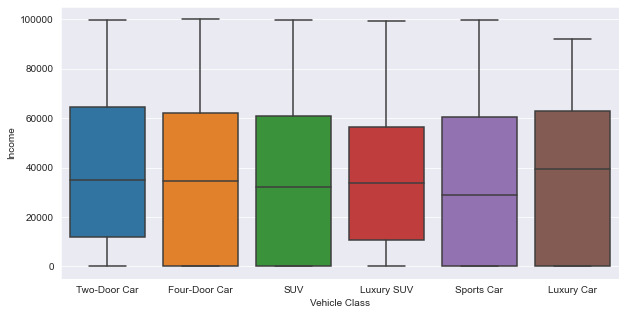

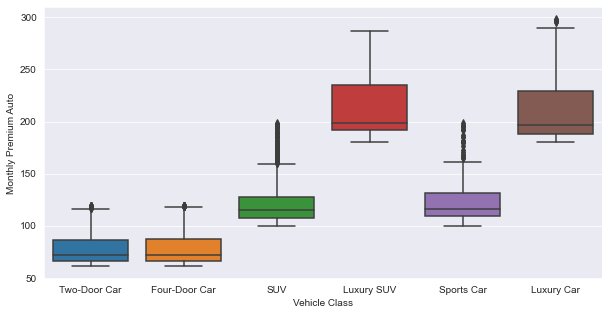

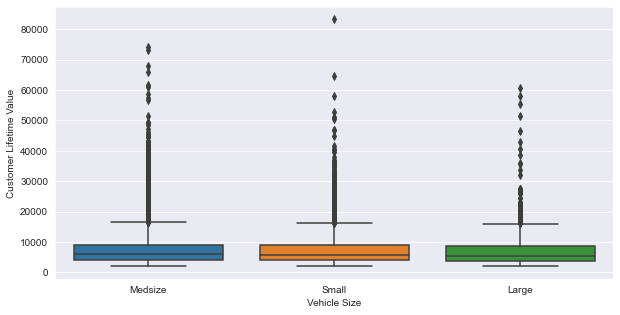

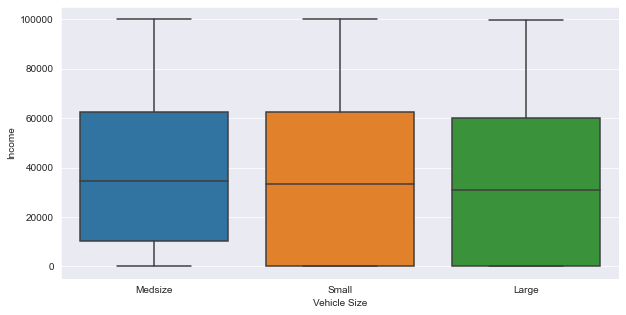

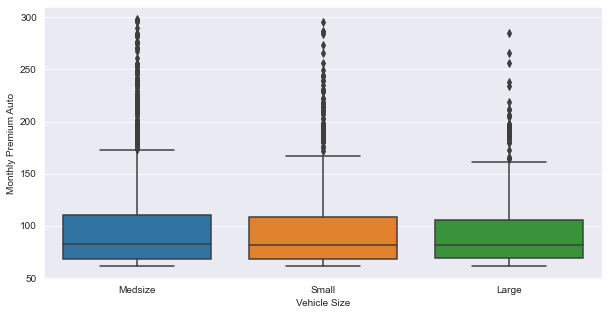

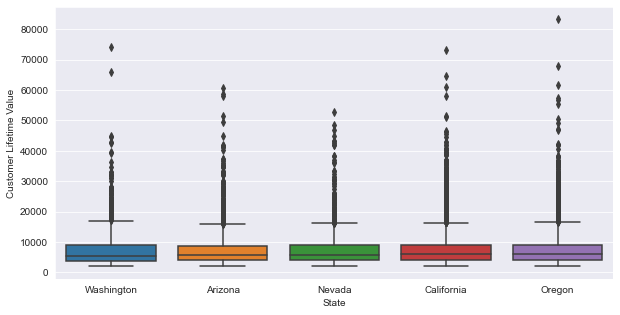

In [22]:
# Box-plots

sns.set_style('darkgrid')
def box(x, y):
    plt.figure(figsize=(10,5))   
    ax = sns.boxplot(x, y, data=df)
    ax.set_xticklabels(ax.get_xticklabels())

box('Coverage', 'Customer Lifetime Value')
box('Coverage', 'Income')
box('Coverage', 'Monthly Premium Auto')

box('Education', 'Customer Lifetime Value')
box('Education', 'Income')
box('Education', 'Monthly Premium Auto')

box('EmploymentStatus', 'Customer Lifetime Value')

box('Location Code', 'Customer Lifetime Value')
box('Location Code', 'Income')
box('Location Code', 'Monthly Premium Auto')

box('Renew Offer Type', 'Customer Lifetime Value')
box('Renew Offer Type', 'Income')
box('Renew Offer Type', 'Monthly Premium Auto')

box('Vehicle Class', 'Customer Lifetime Value')
box('Vehicle Class', 'Income')
box('Vehicle Class', 'Monthly Premium Auto')

box('Vehicle Size', 'Customer Lifetime Value')
box('Vehicle Size', 'Income')
box('Vehicle Size', 'Monthly Premium Auto')

box('State', 'Customer Lifetime Value')
#Varuables I feel need not be included for predictive modeling: Education, Policy type, sales channel, vehicle size

1. Mean Customer Lifetime Value shifts slightly as Coverage type changes, and Coverage definitely influences Monthly auto premium. But it has very minimal association with Income. Hence, income is not a prominent factor based on which a person decides the type of coverage they want. 
2. Education has no visible impact on mean Customer Lifetime Value and no significant association with Income or Monthly auto premium being charged to the customer. But there is considerable variability in Customer Lifetime Value within each Education category.
3. Employment status, Location code and Renew Offer Type too shows minimal change across categories for their mean Customer Lifetime Values, but there is ample variation within categories.
4. mean Customer Lifetime value shows considerable shifts as per vehicle class, with the Luxury categories displaying visibly more Lifetime values.
5. The state a person belongs to seems to have no visible impact on lifetime.

We shall run the regression model and retain those variables that show significance.

# Predictive Modeling: 

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats

In [6]:
AIC=[]
error_skew=[]

In [7]:
#We are removing irrelevant variables.
df.drop(['Customer', 'Effective To Date', 'Gender', 'Response'], axis=1, inplace=True)

## Encoding Categorical features- Linear Regression- Model Evaluation: 

In [8]:
def visual(y_test, pred):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(y_test, pred, c='red')
    plt.subplot(1,2,2)
    sns.distplot(y_test-pred)
    plt.xlabel('errors')
    print("MAE: ", round(metrics.mean_absolute_error(y_test, pred), 4), "\nMSE: ", 
      round(metrics.mean_squared_error(y_test, pred), 4), "\nRMSE: ", 
      round(np.sqrt(metrics.mean_squared_error(y_test, pred)), 4))  
    print("Skewness of error distribution: ", (y_test-pred).skew())
    error_skew.append((y_test-pred).skew())
    
def linreg(x_train, x_test, y_train, y_test):
    x2 = sm.add_constant(x_train)
    est = sm.OLS(y_train, x2)
    est2 = est.fit()
    AIC.append(est2.aic)
    print(est2.summary())
    print("\nAIC: ", est2.aic)
    
    lm=LinearRegression()
    lm.fit(x_train, y_train)
    print("\nintercept: ", lm.intercept_, "\n", "R^2: ", lm.score(x_train, y_train))
    pred=lm.predict(x_test)
    visual(y_test, pred)

def catencode(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)
    cat_x_train=x_train.loc[:, df.dtypes == np.object]
    ohe=OneHotEncoder(drop='first', sparse=False)
    x_train2=ohe.fit_transform(cat_x_train)
    x_train2=pd.DataFrame(x_train2, index=x_train.index, columns=ohe.get_feature_names(cat_x_train.columns))
    x_train=pd.concat([x_train, x_train2], axis=1)
    x_train.drop(cat_x_train.columns, axis=1, inplace=True)

    x_test2=ohe.transform(x_test[cat_x_train.columns])
    x_test2=pd.DataFrame(x_test2, index=x_test.index, columns=ohe.get_feature_names(cat_x_train.columns))
    x_test=pd.concat([x_test, x_test2], axis=1)
    x_test.drop(cat_x_train.columns, axis=1, inplace=True)
    return x_train, x_test, y_train, y_test

### Linear Regression Model 1: 

                               OLS Regression Results                              
Dep. Variable:     Customer Lifetime Value   R-squared:                       0.178
Model:                                 OLS   Adj. R-squared:                  0.173
Method:                      Least Squares   F-statistic:                     32.85
Date:                     Thu, 20 Aug 2020   Prob (F-statistic):          4.46e-235
Time:                             22:59:26   Log-Likelihood:                -65001.
No. Observations:                     6393   AIC:                         1.301e+05
Df Residuals:                         6350   BIC:                         1.304e+05
Df Model:                               42                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

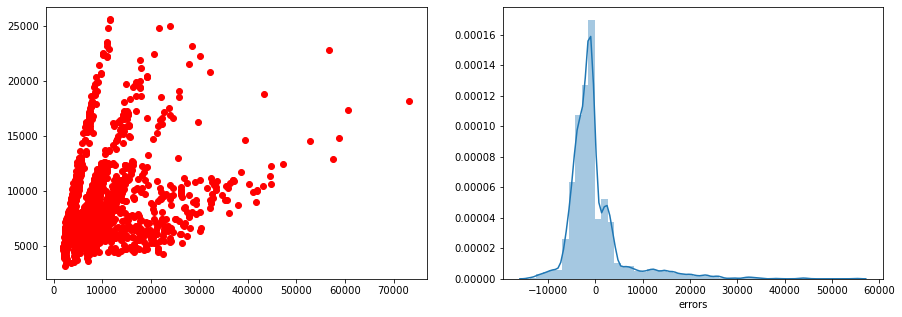

In [9]:
# x=df.drop(['Customer Lifetime Value', 'Number of Policies', 'Months Since Policy Inception'], axis=1)
x=df.drop('Customer Lifetime Value', axis=1)
y=df['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

In [10]:
3898.9024/df['Customer Lifetime Value'].mean()

0.48706201029012586

The error distribution is highly skewed, indicating that the model needs to be much better. The predicted output could be wrong by an absolute value of 3898.9, which is ~49% of the target variable mean. This is a high error margin.

### Hypothesis Testing: 

- Null H0: None of the regressors are significant to explain changes in the Customer Lifetime Value
- Alternate H1: Atleast 1 of the independednt variables will be significant and able to explain Customer Lifetime Value

The Joint Hypothesis Test described above uses the p-vale asscoiated with the F-statistic: 3.77e-236

p(F-stat) is <0.05, i.e. it's < than 5%. Hence Null H0 rejected. 

Conclusion: Atleast one of the regressors ARE significant and can explain the dependent variable.

However R^2 is just 17.8%, i.e. model is able to explain the target variable only upto 17.8%, which is very less.

### Linear Regression Model 2:

Dropped insignificant variables to re-run the model:

                               OLS Regression Results                              
Dep. Variable:     Customer Lifetime Value   R-squared:                       0.175
Model:                                 OLS   Adj. R-squared:                  0.173
Method:                      Least Squares   F-statistic:                     90.02
Date:                     Thu, 20 Aug 2020   Prob (F-statistic):          4.27e-252
Time:                             22:59:36   Log-Likelihood:                -65016.
No. Observations:                     6393   AIC:                         1.301e+05
Df Residuals:                         6377   BIC:                         1.302e+05
Df Model:                               15                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

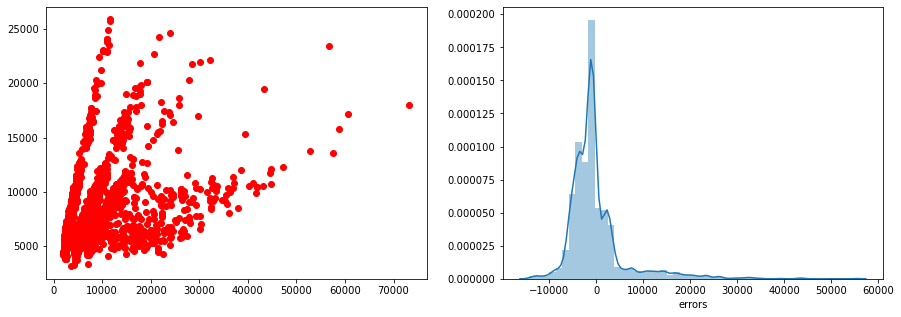

In [11]:
x=df[['Monthly Premium Auto', 'Number of Open Complaints', 'EmploymentStatus', 'Policy', 'Renew Offer Type']]
y=df['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

The model shows no considerable improvement even after including only significant variables. The error distribution is still heavily skewed and R^2 is still too low.

### Linear Regression Model 3 (Select records): 

We shall next consider only those records where Number of policies is 1 or 2 and Months since inception is 12 or less- as a quick check.

                               OLS Regression Results                              
Dep. Variable:     Customer Lifetime Value   R-squared:                       0.671
Model:                                 OLS   Adj. R-squared:                  0.642
Method:                      Least Squares   F-statistic:                     22.53
Date:                     Thu, 20 Aug 2020   Prob (F-statistic):           8.51e-87
Time:                             22:59:43   Log-Likelihood:                -4987.4
No. Observations:                      506   AIC:                         1.006e+04
Df Residuals:                          463   BIC:                         1.024e+04
Df Model:                               42                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

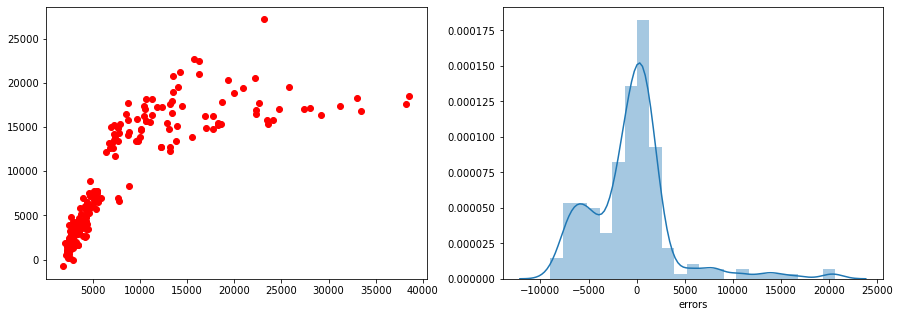

In [12]:
df1=df[(df['Number of Policies']<3) & (df['Months Since Policy Inception']<13)]
x=df1.drop('Customer Lifetime Value', axis=1)
y=df1['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

- R^2 has improved and risen to 67%
- p-value of the F-stat -although higher than the previous value- tells us that the model is significant (i.e. there is atleast one significant regressor which can explain the dependent variable)
- AIC has decreased as opposed to the previous model, which indicates a better model. 
- However, fewer regressors are significant now.
- The predicted output could be wrong by an absolute value of 2990.6, which is ~37% of the target variable mean. This is still, a high error margin.
- The error distribution is less skewed than before, but still highly skewed.

### Linear Regression Model 4 (Select records): 

Dropped all the insignificant variables to re-run the model:

                               OLS Regression Results                              
Dep. Variable:     Customer Lifetime Value   R-squared:                       0.650
Model:                                 OLS   Adj. R-squared:                  0.646
Method:                      Least Squares   F-statistic:                     185.3
Date:                     Thu, 20 Aug 2020   Prob (F-statistic):          2.26e-111
Time:                             22:59:47   Log-Likelihood:                -5003.8
No. Observations:                      506   AIC:                         1.002e+04
Df Residuals:                          500   BIC:                         1.004e+04
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

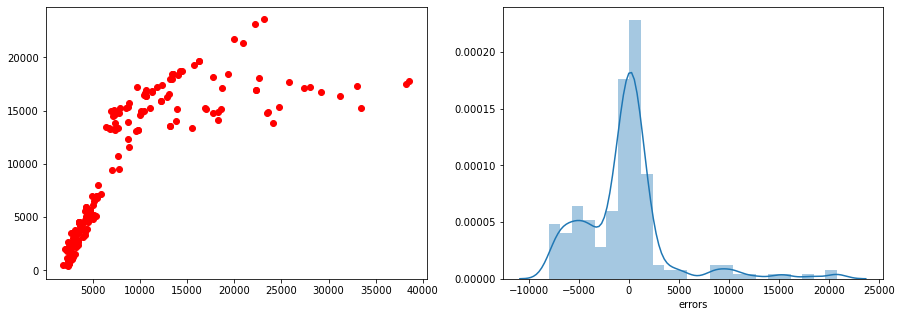

In [13]:
x=df1[['Monthly Premium Auto', 'Number of Policies', 'Renew Offer Type']]
y=df1['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

The error distribution is heavily skewed and similar to previous value. However, all the variables are significant now, model has joint significance, and AIC value is the lowest when comparing to the previous 3 models.

## Linear Regression with Log transformation (Log-linear model):

In [14]:
from math import log

In [15]:
for i in df.loc[:, (df.dtypes == np.int64) | (df.dtypes == np.float64)].columns:
    print("Skew "+i+": ", df[i].skew())

Skew Customer Lifetime Value:  3.032280259929985
Skew Income:  0.28688727581189166
Skew Monthly Premium Auto:  2.1235464499475345
Skew Months Since Last Claim:  0.2785863118107981
Skew Months Since Policy Inception:  0.040164961597799524
Skew Number of Open Complaints:  2.783263052399567
Skew Number of Policies:  1.2533327352739663
Skew Total Claim Amount:  1.7149658097209557


In [16]:
df['lnCLTV']=df['Customer Lifetime Value'].apply(lambda x:log(x))

### Linear Regression Model 5:

                            OLS Regression Results                            
Dep. Variable:                 lnCLTV   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     55.01
Date:                Thu, 20 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:00:01   Log-Likelihood:                -5387.2
No. Observations:                6393   AIC:                         1.086e+04
Df Residuals:                    6350   BIC:                         1.115e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

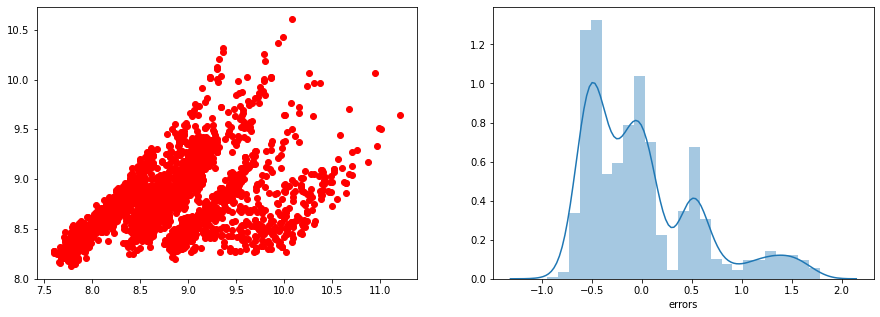

In [17]:
x=df.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df['lnCLTV']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

In [18]:
0.4366/df['lnCLTV'].mean()

0.04990534568507675

The error distribution is less skewed than before, and it still has joint significance. However neither the R^2, nor the AIC value has improved. 

The Mean Absolute error has, however, improved: The predicted output could be wrong by an absolute value of 0.436, which is ~5% of the target variable mean. This is a graet improvement as compared to before.

Let's re-run the model, after eliminating the insignificant variables.

### Linear Regression Model 6:

                            OLS Regression Results                            
Dep. Variable:                 lnCLTV   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     91.87
Date:                Thu, 20 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:00:10   Log-Likelihood:                -5394.6
No. Observations:                6393   AIC:                         1.084e+04
Df Residuals:                    6367   BIC:                         1.102e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

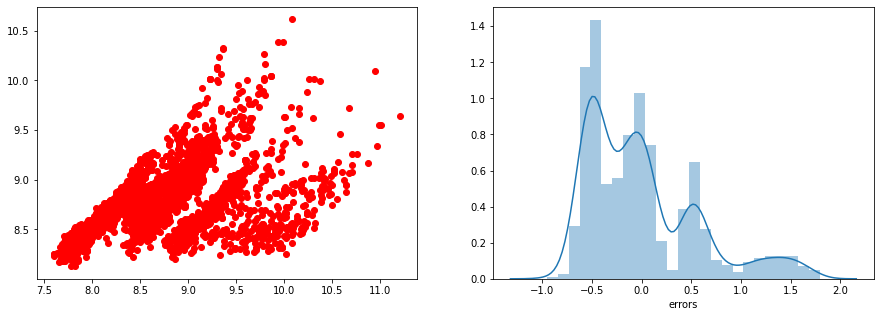

In [19]:
x=df[['Monthly Premium Auto', 'Number of Open Complaints', 'Number of Policies', 'Coverage', 'EmploymentStatus',
     'Marital Status', 'Policy', 'Renew Offer Type', 'Vehicle Class']]
y=df['lnCLTV']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

The model statistics and skew are still about the same as before. This indicates that as discussed in the beginning of this project, important missing variables are causing the models to suffer from the 'Omitted variable bias'. The effects of all the unrepresented variables will be captured in the error term, and this is likely to be highly correlated with explanatory variables like 'Months Since Policy Inception' and 'Number of Policies' etc.

Hence, we shall go ahead and create a log-linear model with only those records where Number of policies is 1 or 2 and Months since inception is 12 or less. There is a possibility for multicollinearity being present as certain expected variables like 'Months Since Policy Inception', which indicates longevity, has shown up as insignificant. Anther eg. is 'Total Claim Amount'. We shall perform collinearity tests (using Variance Inflation factor (VIF)) and endogeneity tests after the same, if the results do not improve significantly.

### Linear Regression Model 7 (Select records):

                            OLS Regression Results                            
Dep. Variable:                 lnCLTV   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     97.33
Date:                Thu, 20 Aug 2020   Prob (F-statistic):          3.89e-202
Time:                        23:00:15   Log-Likelihood:                -38.829
No. Observations:                 506   AIC:                             163.7
Df Residuals:                     463   BIC:                             345.4
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

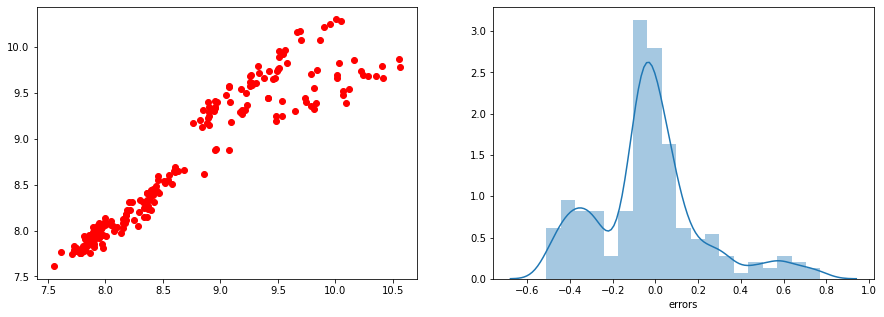

In [20]:
df1=df[(df['Number of Policies']<3) & (df['Months Since Policy Inception']<13)]
x=df1.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df1['lnCLTV']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

In [21]:
print("Model with lowest AIC value: Model ", AIC.index(min(AIC))+1)
print("Model whose error distribution is closest to normality, compared to other models: Model ", 
      error_skew.index(min(error_skew))+1)

Model with lowest AIC value: Model  7
Model whose error distribution is closest to normality, compared to other models: Model  7


The improvement in AIC, error distribution, R^2 and Mean absolute error is very evident when log-transformed dependent variable is used with select records where the previously explained obvious error due to 'Number of Policies' and 'Months Since Policy Inception' is not present.

From the models run so far, one can conclude that model 7 is the best choice.

In [22]:
error_skew

[2.712685228647569,
 2.6927541613441166,
 1.5238178977106196,
 1.752654292002714,
 1.1430005205894689,
 1.1426330058737368,
 0.6678153782379841]

### Random Forest Regression Model 1: All records considered, continuous dependent variable.

R^2:  0.9578
                                 Coefficients
Income                               0.034553
Monthly Premium Auto                 0.250743
Months Since Last Claim              0.047199
Months Since Policy Inception        0.039622
Number of Open Complaints            0.005653
Number of Policies                   0.474730
Total Claim Amount                   0.045327
State_California                     0.003189
State_Nevada                         0.002889
State_Oregon                         0.003146
State_Washington                     0.003520
Coverage_Extended                    0.002275
Coverage_Premium                     0.003258
Education_Doctor                     0.002102
Education_Master                     0.002935
EmploymentStatus_Retired_Others      0.002646
EmploymentStatus_Unemployed          0.002770
Location Code_Suburban               0.001248
Location Code_Urban                  0.002712
Marital Status_Married               0.004268
Marital Status_Single

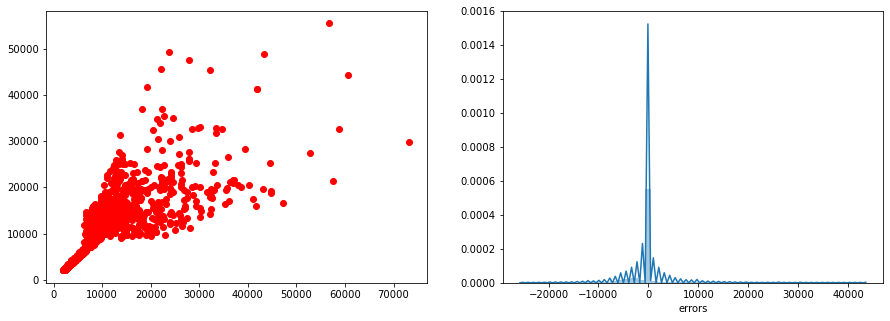

In [23]:
from sklearn.ensemble import RandomForestRegressor
x=df.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)

rfr=RandomForestRegressor()
rfr.fit(x_tr, y_tr)
print("R^2: ", round(rfr.score(x_tr, y_tr), 4))
coefs=pd.DataFrame(rfr.feature_importances_, x_tr.columns, columns=['Coefficients'])
print(coefs)
pred=rfr.predict(x_te)
print("\n")
visual(y_te, pred)

# rfr.feature_importances_

### Random Forest Regression Model 2: Select records considered, continuous dependednt variable.

R^2:  0.9528


MAE:  2211.7181 
MSE:  18474937.2629 
RMSE:  4298.2482
Skewness of error distribution:  0.5665169475758305


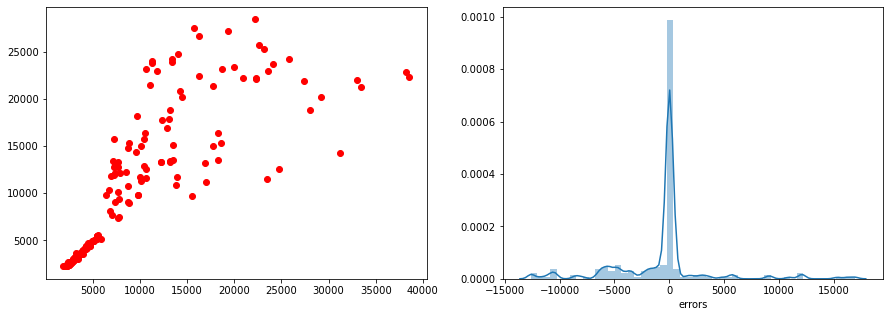

In [24]:
df1=df[(df['Number of Policies']<3) & (df['Months Since Policy Inception']<13)]
x=df1.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df1['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)

rfr=RandomForestRegressor()
rfr.fit(x_tr, y_tr)
print("R^2: ", round(rfr.score(x_tr, y_tr), 4))
pred=rfr.predict(x_te)
print("\n")
visual(y_te, pred)

### Random Forest Regression Model 3: All records considered, log-transformed dependednt variable.

R^2:  0.9867


MAE:  0.0929 
MSE:  0.0383 
RMSE:  0.1957
Skewness of error distribution:  1.16963765310359


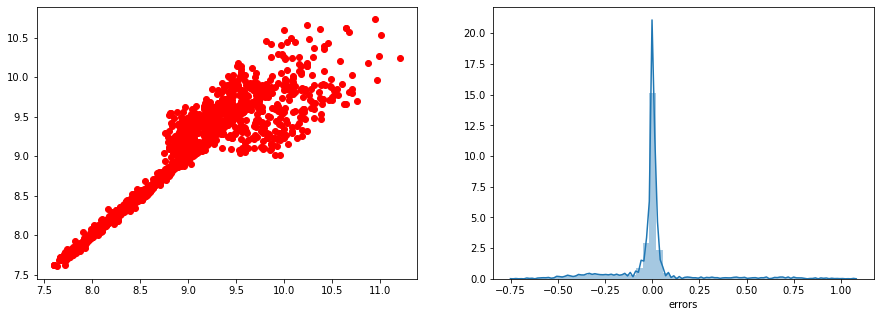

In [25]:
x=df.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df['lnCLTV']
x_tr, x_te, y_tr, y_te = catencode(x, y)

rfr=RandomForestRegressor()
rfr.fit(x_tr, y_tr)
print("R^2: ", round(rfr.score(x_tr, y_tr), 4))
pred=rfr.predict(x_te)
print("\n")
visual(y_te, pred)

In [26]:
0.0922/df['lnCLTV'].mean()

0.01053887510802583

The MAE has dropped to ~1% of the target column mean.

### Random Forest Regression Model 4: Select records considered, log-transformed dependednt variable.

R^2:  0.9849


MAE:  0.1374 
MSE:  0.0564 
RMSE:  0.2375
Skewness of error distribution:  0.3587093411596262


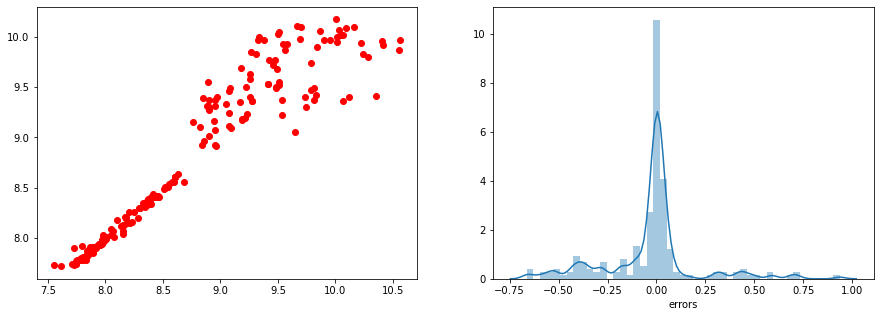

In [27]:
x=df1.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df1['lnCLTV']
x_tr, x_te, y_tr, y_te = catencode(x, y)

rfr=RandomForestRegressor()
rfr.fit(x_tr, y_tr)
print("R^2: ", round(rfr.score(x_tr, y_tr), 4))
pred=rfr.predict(x_te)
print("\n")
visual(y_te, pred)

This seems to be the best Random forest model so far with an approx. normal error distribution and low MAE (~1.6%) and similar R^2 as before (98.6%). However, since we cannot differentiate between regressors that have +ve and -ve impact on the dependent variable in Tree models, we shall explore few more options like collinearity testing, PCA, SVM, Neural networks etc. for this project.

#-------------------------------------- End of Phase1 ----------------------------------------------------#

### Collinearity test using Variance Inflation Factor (VIF):

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [29]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [99]:
x=df.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
calc_vif(x_tr)

C:\Users\Roshiny Thomas\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,Income,7.507927
1,Monthly Premium Auto,94.237824
2,Months Since Last Claim,3.189757
3,Months Since Policy Inception,3.989092
4,Number of Open Complaints,1.189630
5,Number of Policies,2.578433
6,Total Claim Amount,13.565247
7,State_California,2.861039
8,State_Nevada,1.547633
9,State_Oregon,2.564363


VIF >10 signifies high multicollinearity, i.e. the variable in question can be easily predicted by other independent variables in the dataset. We shall remove one correlated variable and see to what extent the collinearity problem improves. VIF ='inf' means there is perfect correlation with other independent variables. Hence, we will begin by removing 'Policy Type'.

In [101]:
x=df.drop(['Customer Lifetime Value', 'lnCLTV', 'Policy Type'], axis=1)
y=df['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
calc_vif(x_tr)

,variables,VIF
0,Income,7.507927
1,Monthly Premium Auto,94.237824
2,Months Since Last Claim,3.189757
3,Months Since Policy Inception,3.989092
4,Number of Open Complaints,1.189630
5,Number of Policies,2.578433
6,Total Claim Amount,13.565247
7,State_California,2.861039
8,State_Nevada,1.547633
9,State_Oregon,2.564363


We notice that after dropping 'Policy Type', VIF values of 'Policy' variable has dropped rastically. We will next drop 'Monthly Premium Auto', as it still displays high VIF, 94.

In [102]:
x=df.drop(['Customer Lifetime Value', 'lnCLTV', 'Policy Type', 'Monthly Premium Auto'], axis=1)
y=df['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
calc_vif(x_tr)

,variables,VIF
0,Income,6.641803
1,Months Since Last Claim,3.115049
2,Months Since Policy Inception,3.838374
3,Number of Open Complaints,1.186941
4,Number of Policies,2.529211
5,Total Claim Amount,13.278366
6,State_California,2.767900
7,State_Nevada,1.522890
8,State_Oregon,2.482724
9,State_Washington,1.451796


Dropping 'Total Claim Amount' as it still has high a VIF, 13.27

In [103]:
x=df.drop(['Customer Lifetime Value', 'lnCLTV', 'Policy Type', 'Monthly Premium Auto', 'Total Claim Amount'], axis=1)
y=df['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
calc_vif(x_tr)

,variables,VIF
0,Income,6.633380
1,Months Since Last Claim,3.113919
2,Months Since Policy Inception,3.838169
3,Number of Open Complaints,1.186891
4,Number of Policies,2.528384
5,State_California,2.766784
6,State_Nevada,1.522191
7,State_Oregon,2.482717
8,State_Washington,1.451472
9,Coverage_Extended,1.499370


There are no more variables with high VIF values, i.e. VIF >10. Hence, we will create few models using this new training set, which has much reduced multicollinearity.

First up: Linear regression model with continuous dependent variable: 'Customer Lifetime Value'

### Linear regression model 8 - Continuous dependent variable: 'Customer Lifetime Value':

                               OLS Regression Results                              
Dep. Variable:     Customer Lifetime Value   R-squared:                       0.172
Model:                                 OLS   Adj. R-squared:                  0.167
Method:                      Least Squares   F-statistic:                     33.06
Date:                     Wed, 19 Aug 2020   Prob (F-statistic):          1.42e-226
Time:                             02:49:51   Log-Likelihood:                -65025.
No. Observations:                     6393   AIC:                         1.301e+05
Df Residuals:                         6352   BIC:                         1.304e+05
Df Model:                               40                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

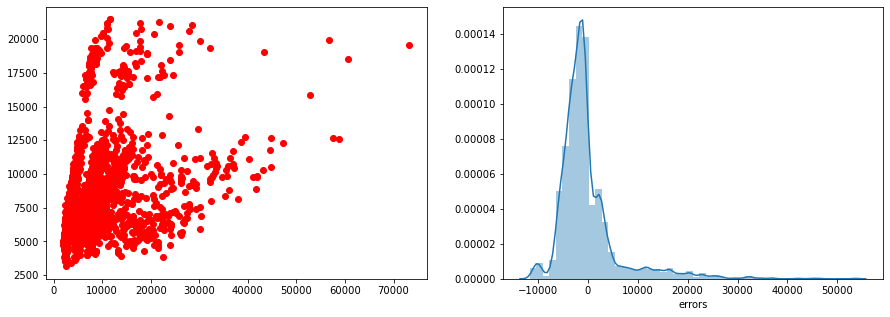

In [106]:
linreg(x_tr, x_te, y_tr, y_te)

### Linear regression model 9 - log-transformed dependent variable: 'lnCLTV':

                            OLS Regression Results                            
Dep. Variable:                 lnCLTV   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     56.08
Date:                Wed, 19 Aug 2020   Prob (F-statistic):               0.00
Time:                        02:52:07   Log-Likelihood:                -5412.4
No. Observations:                6393   AIC:                         1.091e+04
Df Residuals:                    6352   BIC:                         1.118e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

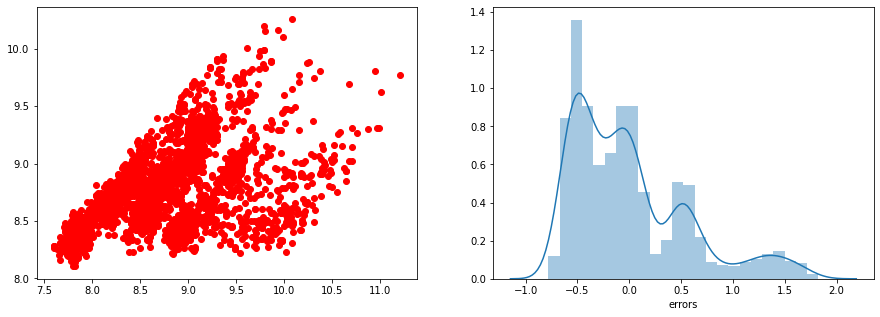

In [108]:
x=df.drop(['Customer Lifetime Value', 'lnCLTV', 'Policy Type', 'Monthly Premium Auto', 'Total Claim Amount'], axis=1)
y=df['lnCLTV']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

We notice that even after fixing multicollinearity problems, the model does not display improved results, neither with continuous dependent variable or log-transformed dependent variable. We can hence try PCA.

### Principal Component Analysis: 

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [31]:
x=df.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df['lnCLTV']
x_tr, x_te, y_tr, y_te = catencode(x, y)

In [32]:
lm=LinearRegression()
sc=StandardScaler()
sc.fit(x_tr)
scaled_train=sc.transform(x_tr)
scaled_train=pd.DataFrame(scaled_train, index=x_tr.index, columns=x_tr.columns)
scaled_test=sc.transform(x_te)
scaled_test=pd.DataFrame(scaled_test, index=x_te.index, columns=x_te.columns)

#### Screeplot:

Text(0, 0.5, 'explained variance R^2')

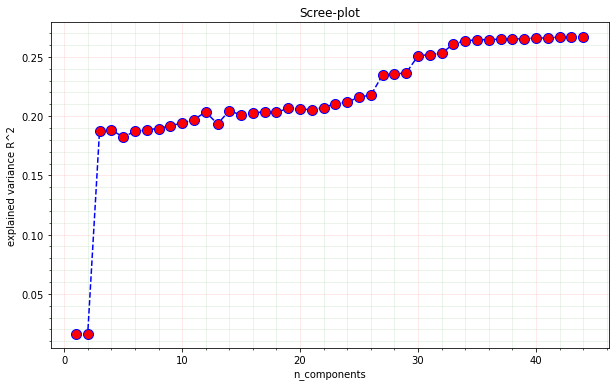

In [72]:
error=[]
for i in range(1,45):
    pca=PCA(n_components=i)
    pca.fit(scaled_train)
    pca_train=pca.transform(scaled_train)
    lm.fit(pca_train, y_tr)
    error.append(lm.score(pca_train, y_tr))
# plt.figure(figsize=(10,6))
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(range(1,45), error, color='blue', linestyle='--', marker='o', markerfacecolor='red', markersize=10)
plt.grid(b=True, which='major', color='red', linestyle='-', alpha=0.1)
# ax.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='green', linestyle='-', alpha=0.1)
plt.title("Scree-plot")
plt.xlabel("n_components")
plt.ylabel("explained variance R^2")

n_components=4 seems like a good choice; But we can already see that very little variation in the dependent variable is explainable even after PCA, about ~ 16%

### Linear regression model 10 - continuous dependent variable: 'Customer Lifetime Value' - with PCA

                            OLS Regression Results                            
Dep. Variable:                 lnCLTV   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     370.3
Date:                Thu, 20 Aug 2020   Prob (F-statistic):          3.12e-287
Time:                        15:25:26   Log-Likelihood:                -5712.5
No. Observations:                6393   AIC:                         1.144e+04
Df Residuals:                    6388   BIC:                         1.147e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7465      0.007   1182.182      0.0

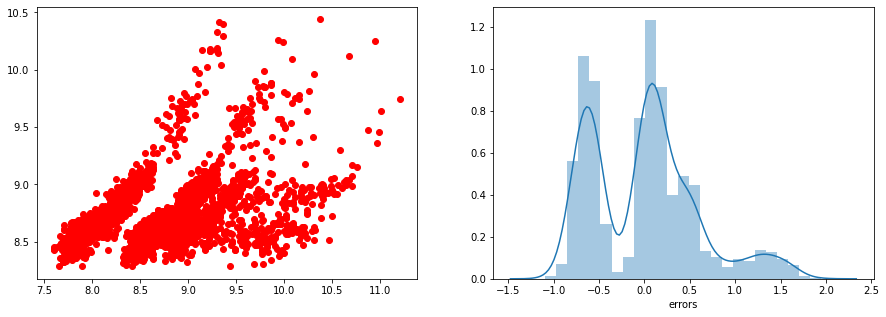

In [73]:
pca=PCA(n_components=4)
pca.fit(scaled_train)
pca_train=pca.transform(scaled_train)
pca_test=pca.transform(scaled_test)
linreg(pca_train, pca_test, y_tr, y_te)

The model shows no considerable improvement even after PCA is done. R^2 is just ~19% and the error distributions are not approx. normal either.

### Support Vector Machine- Regression (SVR):

We shall use the scaled data.

In [74]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid= GridSearchCV(SVR(), param_grid, verbose=5)
grid.fit(scaled_train, y_tr)
print("The chosen values of c & gamma: ", grid.best_params_)
print("The best estimator: ", grid.best_estimator_)
pred=grid.predict(scaled_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... C=0.1, gamma=1, score=-0.006, total=   5.6s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, score=0.002, total=   5.6s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s


[CV] ..................... C=0.1, gamma=1, score=-0.003, total=   5.6s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.7s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, score=0.002, total=   5.6s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.3s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, score=0.005, total=   5.6s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.106, total=   4.1s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.093, total=   4.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.109, total=   3.9s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.110, total=   4.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.110, total=   3.9s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................... C=0.1, gamma=0.01, score=0.166, total=   3.9s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[CV] .................... C=10, gamma=0.01, score=0.314, total=   9.0s
[CV] C=10, gamma=0.01 ................................................
[CV] .................... C=10, gamma=0.01, score=0.301, total=   8.8s
[CV] C=10, gamma=0.01 ................................................
[CV] .................... C=10, gamma=0.01, score=0.331, total=   9.3s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................... C=10, gamma=0.001, score=0.171, total=   4.4s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................... C=10, gamma=0.001, score=0.171, total=   4.5s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................... C=10, gamma=0.001, score=0.251, total=   4.5s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................... C=10, gamma=0.001, score=0.223, total=   4.5s
[CV] C=10, gamma=0.001 ...............................................
[CV] .

[CV] ................ C=1000, gamma=0.0001, score=0.174, total=   4.5s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ................ C=1000, gamma=0.0001, score=0.176, total=   4.5s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ................ C=1000, gamma=0.0001, score=0.253, total=   4.5s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ................ C=1000, gamma=0.0001, score=0.226, total=   4.5s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ................ C=1000, gamma=0.0001, score=0.268, total=   4.5s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 27.4min finished


The chosen values of c & gamma:  {'C': 10, 'gamma': 0.01}
The best estimator:  SVR(C=10, gamma=0.01)


MAE:  0.369 
MSE:  0.2851 
RMSE:  0.534
Skewness of error distribution:  1.332075820612277


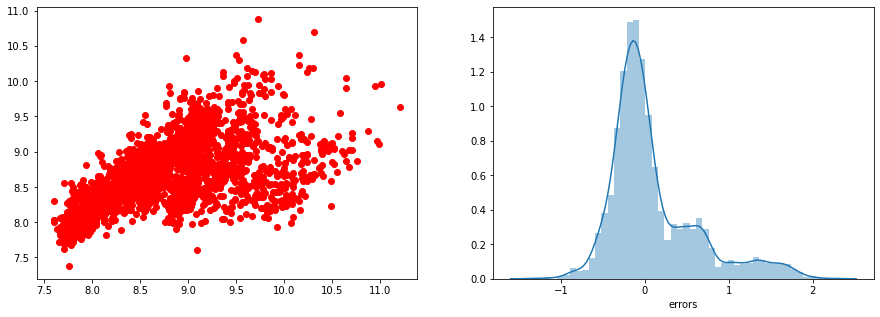

In [75]:
visual(y_te, pred)

The skew of the error distribution still indicates non-normality, and there are already models with lower MAE values. We can conclude that SVR, too, is an unsuccessful model, even with a log-transformed dependent variable.

## Deep Neural Networks:

In [36]:
x=df.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df['lnCLTV']
x_tr, x_te, y_tr, y_te = catencode(x, y)
X_tr=x_tr.values
X_te=x_te.values
Y_tr=y_tr.values
Y_te=y_te.values

#### Normalization using MinMax scaler:

In [34]:
from sklearn.preprocessing import MinMaxScaler

In [37]:
sc=MinMaxScaler()
sc.fit(X_tr)
scaled_train=sc.transform(X_tr)
scaled_test=sc.transform(X_te)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [232]:
model=Sequential()
model.add(Dense(44, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(22, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

Train on 6393 samples, validate on 2741 samples
Epoch 1/600
6393/6393 [==============================] - 4s 627us/sample - loss: 1.8588 - val_loss: 0.6771
Epoch 2/600
6393/6393 [==============================] - 1s 134us/sample - loss: 1.5902 - val_loss: 0.5917
Epoch 3/600
6393/6393 [==============================] - 1s 133us/sample - loss: 1.4988 - val_loss: 0.4820
Epoch 4/600
6393/6393 [==============================] - 1s 131us/sample - loss: 1.3632 - val_loss: 0.4289
Epoch 5/600
6393/6393 [==============================] - 1s 132us/sample - loss: 1.2842 - val_loss: 0.4238
Epoch 6/600
6393/6393 [==============================] - 1s 129us/sample - loss: 1.2299 - val_loss: 0.3827
Epoch 7/600
6393/6393 [==============================] - 1s 131us/sample - loss: 1.2132 - val_loss: 0.3824
Epoch 8/600
6393/6393 [==============================] - 1s 132us/sample - loss: 1.1495 - val_loss: 0.3727
Epoch 9/600
6393/6393 [==============================] - 1s 143us/sample - loss: 1.1083 - val_lo

6393/6393 [==============================] - 1s 128us/sample - loss: 0.2446 - val_loss: 0.1018
Epoch 77/600
6393/6393 [==============================] - 1s 128us/sample - loss: 0.2359 - val_loss: 0.0959
Epoch 78/600
6393/6393 [==============================] - 1s 129us/sample - loss: 0.2341 - val_loss: 0.0976
Epoch 79/600
6393/6393 [==============================] - 1s 127us/sample - loss: 0.2291 - val_loss: 0.0979
Epoch 80/600
6393/6393 [==============================] - 1s 129us/sample - loss: 0.2244 - val_loss: 0.1020
Epoch 81/600
6393/6393 [==============================] - 1s 132us/sample - loss: 0.2237 - val_loss: 0.0928
Epoch 82/600
6393/6393 [==============================] - 1s 133us/sample - loss: 0.2206 - val_loss: 0.1000
Epoch 83/600
6393/6393 [==============================] - 1s 131us/sample - loss: 0.2215 - val_loss: 0.1007
Epoch 84/600
6393/6393 [==============================] - 1s 130us/sample - loss: 0.2083 - val_loss: 0.0962
Epoch 85/600
6393/6393 [=================

6393/6393 [==============================] - 1s 127us/sample - loss: 0.0562 - val_loss: 0.0503
Epoch 152/600
6393/6393 [==============================] - 1s 133us/sample - loss: 0.0563 - val_loss: 0.0496
Epoch 153/600
6393/6393 [==============================] - 1s 131us/sample - loss: 0.0541 - val_loss: 0.0503
Epoch 154/600
6393/6393 [==============================] - 1s 128us/sample - loss: 0.0564 - val_loss: 0.0494
Epoch 155/600
6393/6393 [==============================] - 1s 129us/sample - loss: 0.0567 - val_loss: 0.0490
Epoch 156/600
6393/6393 [==============================] - 1s 130us/sample - loss: 0.0568 - val_loss: 0.0524
Epoch 157/600
6393/6393 [==============================] - 1s 133us/sample - loss: 0.0525 - val_loss: 0.0509
Epoch 158/600
6393/6393 [==============================] - 1s 130us/sample - loss: 0.0529 - val_loss: 0.0508
Epoch 159/600
6393/6393 [==============================] - 1s 131us/sample - loss: 0.0550 - val_loss: 0.0498
Epoch 160/600
6393/6393 [========

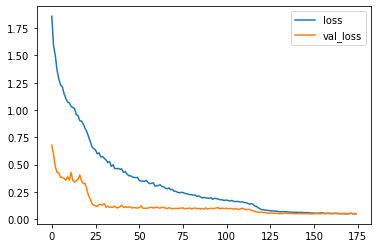

In [234]:
model.compile(optimizer='adam', loss='mse')
early=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
model.fit(x=scaled_train, y=Y_tr, validation_data=(scaled_test, Y_te), callbacks=[early], epochs=600, )
pd.DataFrame(model.history.history).plot()

#### Neural network model evaluation:

Test set MSE: 0.05163271007658448
Train set MSE: 0.026766444048725548
Skew of error distribution:  2.328163238745764


Text(0.5, 0, 'errors')

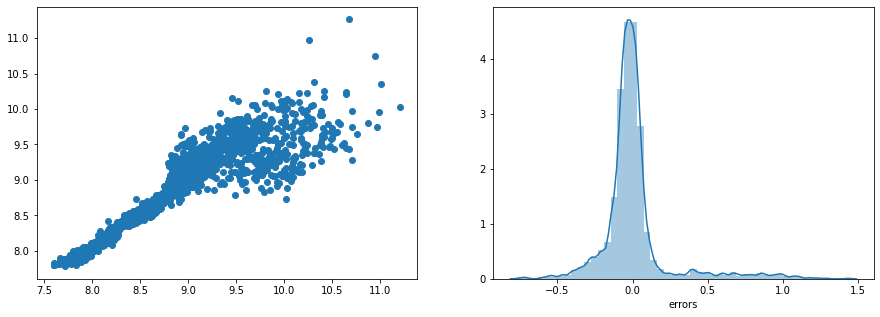

In [235]:
#gives MSE value, since our loss function (loss) is 'mse'
print("Test set MSE:", model.evaluate(scaled_test, Y_te, verbose=0))
print("Train set MSE:", model.evaluate(scaled_train, Y_tr, verbose=0))
pred=model.predict(scaled_test)
pred_df=pd.concat([pd.DataFrame(Y_te, columns=['True_Y']), pd.DataFrame(pred, columns=['Predictions'])], axis=1)
print("Skew of error distribution: ", (pred_df['True_Y']-pred_df['Predictions']).skew())

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(pred_df['True_Y'], pred_df['Predictions'])
plt.subplot(1,2,2)
sns.distplot(pred_df['True_Y']-pred_df['Predictions'])
plt.xlabel('errors')

The preliminary Deep Neural network has not shown significant model improvement over the Log-linear model or Random Forest model. However, further tuning of parameters etc. can be considered for Neural Networks.

## Conclusions:

1. It can be ascertained from the analysis and the models that there are severe errors in the data, particularly with the 'Number of Policies' and 'Months Since Policy Inception' variable, as explained before.
2. It is highly possible that there are crucial missing variables like Policy length, Payment Gaps, Policy relapse periods, Number of vehicles insured etc.
3. Information related to Policy length, Payment Gaps, Policy relapse periods directly affects 'Months Since Policy Inception' and Number of vehicles directly affects 'Number of Policies'. Indirect associations too, exist.
4. These missing variables can cause omitted-variable bias, which can overstate or understate the effects of variables existing in the dataset, that are correlated to it. 
5. Or it could cause the error term to be large and correlated with existing regressor(s), causing endogeneity.
6. The joint F-test for all models confirm relevance, i.e. there exists atleast one significant regressor.
7. The data also tested positive for multicollinearity; However, PCA was unable to give improved results.
8. When all the models are evaluated and compared, the better results are shown by those that have log-transformed dependent variable and/or number of records corresponded only to those that had 1 or 2 policies, with less than 12 months since inception.
9. Since CLTV is heavily right-skewed, log transformimg makes it more centered or normalised for a linear regression.

TLDR:

Model 7 is the model of choice: 
- Log-transformed dependent (lnCLTV)
- Select records only
- Approx. normal error distribution
- Appropriately low MAE, about ~1.6% deviation as compared to mean of lnCLTV.
- R^2 of 89.82%
- Lowest AIC of all models (163)